In [73]:
import os
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [74]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [75]:
%cd '/content/gdrive/My Drive/pokepredict/types'

/content/gdrive/My Drive/pokepredict/types


In [76]:
df_train = pd.read_csv("data/type_encodings.csv")
print(df_train.shape)
df_train.head()

(8430, 19)


,file,type_Bug,type_Dark,type_Dragon,type_Electric,type_Fairy,type_Fighting,type_Fire,type_Flying,type_Ghost,type_Grass,type_Ground,type_Ice,type_Normal,type_Poison,type_Psychic,type_Rock,type_Steel,type_Water
0,0001.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,0002.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,0003.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0004.png,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0005.png,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [77]:
target_cols = df_train.drop(['file'], axis=1).columns.to_list()

number_classes = len(target_cols)
image_size = 128
number_epochs = 20

batch_size = 32

target_cols

['type_Bug',
 'type_Dark',
 'type_Dragon',
 'type_Electric',
 'type_Fairy',
 'type_Fighting',
 'type_Fire',
 'type_Flying',
 'type_Ghost',
 'type_Grass',
 'type_Ground',
 'type_Ice',
 'type_Normal',
 'type_Poison',
 'type_Psychic',
 'type_Rock',
 'type_Steel',
 'type_Water']

In [78]:
def build_decoder(with_labels=True, target_size=(image_size, image_size)):
    def decode(path):
        file_bytes = tf.io.read_file(path)

        image = tf.image.decode_png(file_bytes, channels=3)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, target_size)
        image = preprocess_input(image)
        
        return image
    
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    
    return decode_with_labels if with_labels else decode

In [79]:
def build_augmenter(with_labels=True):
    def augment(image):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_saturation(image, 0.8, 1.2)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_hue(image, 0.2)
        
        return image
    

    def augment_with_labels(image, label):
        return augment(image), label
    
    
    return augment_with_labels if with_labels else augment

In [80]:
def build_dataset(paths, labels=None, bsize=32, decode_function=None, augment_function=None, augment=True):
    if decode_function is None:
        decode_function = build_decoder(labels is not None)

    if augment_function is None:
        augment_function = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dataset = tf.data.Dataset.from_tensor_slices(slices)  
    dataset = dataset.map(decode_function, num_parallel_calls=AUTO)
    dataset = dataset.map(augment_function, num_parallel_calls=AUTO) if augment else dataset

    dataset = dataset.batch(bsize).prefetch(AUTO) 

    return dataset

In [81]:
load_dir = "data/images/"

train_paths = load_dir + df_train['file']

label_cols = df_train.columns[1:]
labels = df_train[label_cols].values

labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [82]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, labels, test_size=0.2, random_state=42)

In [83]:
decoder = build_decoder(with_labels=True, target_size=(image_size, image_size))

data_train = build_dataset(train_paths, train_labels, bsize=batch_size, decode_function=decoder)
data_valid = build_dataset(valid_paths, valid_labels, bsize=batch_size, augment=False, decode_function=decoder)

In [84]:
net = EfficientNetB7(include_top=False, input_shape=(image_size, image_size, 3), weights='imagenet')

output = net.output
output = Dropout(0.75)(output)
output = GlobalAveragePooling2D()(output)
output = Dropout(0.75)(output)
output = Dense(number_classes, activation='sigmoid')(output)

model = Model(inputs=net.input, outputs=output)
model.compile(Adam(lr=0.0005), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(multi_label=True, name='auc')])

258080768/258076736 [==============================] - 1s 0us/step


In [85]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta = 1e-4, min_lr = 1e-6, mode = 'min')
        
ckp = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        
es = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, mode='min', restore_best_weights=True, verbose=1)

In [86]:
history = model.fit(data_train,                      
                    validation_data=data_valid,                                       
                    epochs=number_epochs,
                    callbacks=[rlr,es,ckp],
                    shuffle=True,
                    verbose=1)

Epoch 1/20
211/211 [==============================] - 173s 689ms/step - loss: 0.4647 - auc: 0.5340 - val_loss: 0.2713 - val_auc: 0.5477

Epoch 00001: val_loss improved from inf to 0.27130, saving model to model.h5
Epoch 2/20
211/211 [==============================] - 141s 669ms/step - loss: 0.1898 - auc: 0.8259 - val_loss: 0.2307 - val_auc: 0.7664

Epoch 00002: val_loss improved from 0.27130 to 0.23073, saving model to model.h5
Epoch 3/20
211/211 [==============================] - 142s 671ms/step - loss: 0.1133 - auc: 0.9352 - val_loss: 0.1311 - val_auc: 0.9390

Epoch 00003: val_loss improved from 0.23073 to 0.13109, saving model to model.h5
Epoch 4/20
211/211 [==============================] - 142s 671ms/step - loss: 0.0787 - auc: 0.9680 - val_loss: 0.1441 - val_auc: 0.9308

Epoch 00004: val_loss did not improve from 0.13109
Epoch 5/20
211/211 [==============================] - 141s 669ms/step - loss: 0.0622 - auc: 0.9777 - val_loss: 0.1878 - val_auc: 0.9057

Epoch 00005: ReduceLROnPl

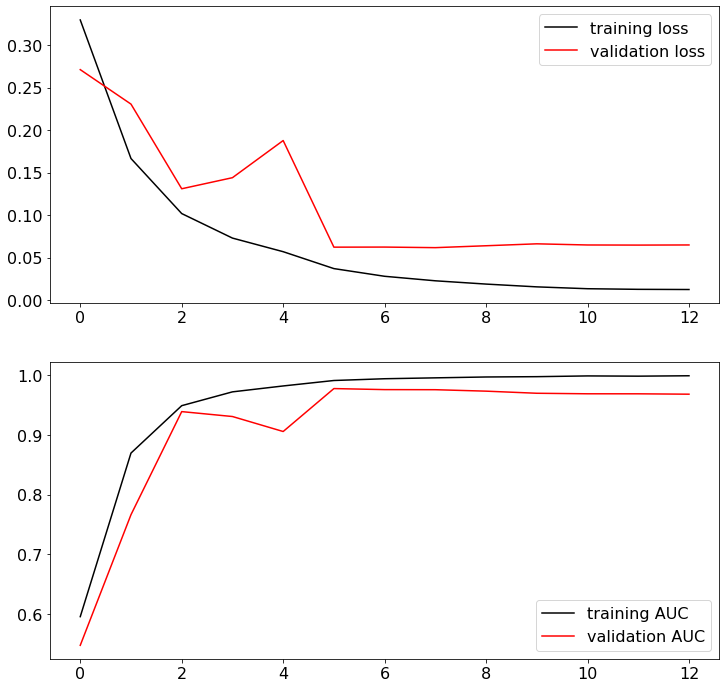

In [87]:
plt.rcParams.update({'font.size': 16})
hist = pd.DataFrame(history.history)
fig, (ax1, ax2) = plt.subplots(figsize=(12,12), nrows=2, ncols=1)

hist['loss'].plot(ax=ax1, c='k', label='training loss')
hist['val_loss'].plot(ax=ax1, c='r', label='validation loss')
ax1.legend()

hist['auc'].plot(ax=ax2, c='k', label='training AUC')
hist['val_auc'].plot(ax=ax2, c='r', label='validation AUC')
ax2.legend()

plt.show()